In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [39]:
rankings = pd.read_csv('FIFA Rankings From 1993 To 2021/fifa_ranking_2014_2022.csv')
rankings = rankings.loc[:,['rank', 'total_points', 'country_full', 'country_abrv', 'rank_date']]
rankings = rankings.replace({"IR Iran": "Iran", "USA": "United States", "Korea Republic": "South Korea"})
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('International Results From 1872 To 2022/results from 2014 to 2022.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup_playoffs = pd.read_csv('Datasets/World Cup 2022 Playoffs Dataset.csv')
world_cup_playoffs = world_cup_playoffs.loc[:, ['Team', 'Way', 'First Match Against', 'Second Match Against']]
world_cup_playoffs = world_cup_playoffs.dropna(how='all')
world_cup_playoffs = world_cup_playoffs.set_index('Team')

world_cup = pd.read_csv('Datasets/World Cup 2022 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First Match Against', 'Second Match Against', 'Third Match Against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.set_index('Team')

In [40]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [41]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['total_points_home'] - matches['total_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'




C:\Users\guinj\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


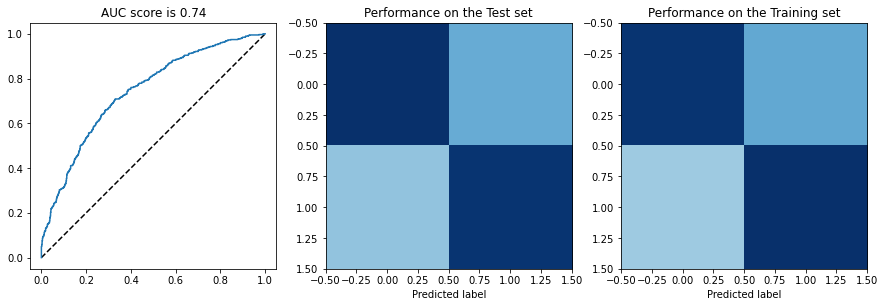

In [42]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Stakes distribution in the wrong predictions
True     0.604167
False    0.395833
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.679849
False    0.320151
Name: is_stake, dtype: float64


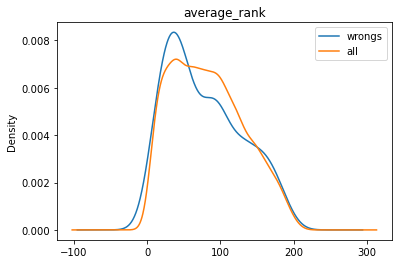

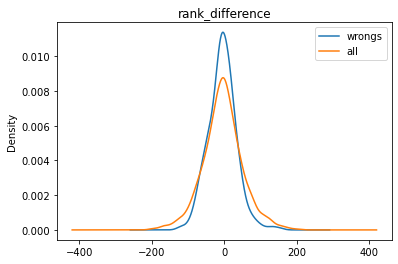

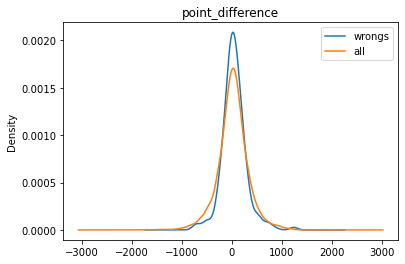

In [43]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

In [44]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_playoffs_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup_playoffs.index.unique())]
world_cup_playoffs_rankings = world_cup_playoffs_rankings.set_index(['country_full'])

world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [45]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup_playoffs['points'] = 0
world_cup_playoffs['total_prob'] = 0

for group in set(world_cup_playoffs['Way']):
    print('___Starting way {}:___'.format(group))
    for home, away in combinations(world_cup_playoffs.query('Way == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_playoffs_rankings.loc[home, 'rank']
        home_points = world_cup_playoffs_rankings.loc[home, 'total_points']
        opp_rank = world_cup_playoffs_rankings.loc[away, 'rank']
        opp_points = world_cup_playoffs_rankings.loc[away, 'total_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup_playoffs.loc[home, 'total_prob'] += home_win_prob
        world_cup_playoffs.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup_playoffs.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup_playoffs.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup_playoffs.loc[home, 'points'] += 1
            world_cup_playoffs.loc[away, 'points'] += 1

___Starting way AFC/CONMEBOL:___
United Arab Emirates vs. Australia: Australia wins with 0.63
United Arab Emirates vs. Peru: Peru wins with 0.71
Australia vs. Peru: Peru wins with 0.60
___Starting way UEFA A:___
Scotland vs. Ukraine: Ukraine wins with 0.56
Scotland vs. Wales: Wales wins with 0.61
Ukraine vs. Wales: Wales wins with 0.55
___Starting way CONCACAF/OFC:___
Costa Rica vs. New Zealand: Costa Rica wins with 0.73


In [46]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group D:___
France vs. Peru: France wins with 0.66
France vs. Denmark: France wins with 0.60
France vs. Tunisia: France wins with 0.70
Peru vs. Denmark: Denmark wins with 0.58
Peru vs. Tunisia: Draw
Denmark vs. Tunisia: Denmark wins with 0.61
___Starting group B:___
England vs. Iran: England wins with 0.64
England vs. United States: England wins with 0.59
England vs. Wales: England wins with 0.62
Iran vs. United States: United States wins with 0.56
Iran vs. Wales: Draw
United States vs. Wales: Draw
___Starting group A:___
Qatar vs. Ecuador: Draw
Qatar vs. Senegal: Senegal wins with 0.64
Qatar vs. Netherlands: Netherlands wins with 0.69
Ecuador vs. Senegal: Senegal wins with 0.63
Ecuador vs. Netherlands: Netherlands wins with 0.68
Senegal vs. Netherlands: Netherlands wins with 0.56
___Starting group E:___
Spain vs. Costa Rica: Spain wins with 0.64
Spain vs. Germany: Draw
Spain vs. Japan: Spain wins with 0.61
Costa Rica vs. Germany: Germany wins with 0.62
Costa Rica vs. Japan

In [47]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'total_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'total_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Netherlands vs. United States: Netherlands wins with probability 0.52
Argentina vs. Denmark: Argentina wins with probability 0.58
Spain vs. Croatia: Spain wins with probability 0.56
Brazil vs. Uruguay: Brazil wins with probability 0.64
Senegal vs. England: England wins with probability 0.64
Mexico vs. France: France wins with probability 0.61
Germany vs. Belgium: Belgium wins with probability 0.64
Switzerland vs. Portugal: Portugal wins with probability 0.54


___Starting of the quarterfinal___
Netherlands vs. Argentina: Argentina wins with probability 0.59
Spain vs. Brazil: Brazil wins with probability 0.60
England vs. France: France wins with probability 0.52
Belgium vs. Portugal: Belgium wins with probability 0.61


___Starting of the semifinal___
Argentina vs. Brazil: Brazil wins with probability 0.56
France vs. Belgium: Belgium wins with probability 0.53


___Starting of the final___
Brazil vs. Belgium: Brazil wins with probability 0.50


